In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/ucsc-cse-144-fall-2023-final-project'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision.datasets import VisionDataset
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset
import re
import pandas as pd
from copy import deepcopy

class CustomTrainImageDataset(Dataset):
    # Initialization method to set up the dataset
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.load_images()

    # Method to load image paths, labels, and filenames
    def load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, filename)
                    # This "label" is wrong
                    label = self.class_to_idx[class_name]
                    # Extract numeric part of the filename (without extension)
                    file_number = int(os.path.splitext(filename)[0])
                    images.append((img_path, label, file_number))
        return images

    # Method to get the length of the dataset
    def __len__(self):
        return len(self.images)

    # Method to get a specific item from the dataset
    # retuns image, label, and filename
    def __getitem__(self, idx):
        img_path, _, filename = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Extract numeric part(in other words, label) of the filename from img_path
        # result = re.search(r'\d+', img_path)
        # if result:
        #     label= int(result.group())
        # else:
        #     ValueError("No number found in string")
        (mydir, myfile) = os.path.split( img_path )

        (_, mylabel) = os.path.split(mydir)

        label = int(mylabel)

        if label < 0 or label >99:  #debug

           print ('label ' + str(label) + "is out of bounds") #debug

           print ('img_path: ' + img_path)  #debug
        return image, label, filename


class CustomTestImageDataset(Dataset):
    # Initialization method to set up the dataset
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = self.load_images()

    # Method to load image paths and filenames for test data
    def load_images(self):
        images = []
        for filename in os.listdir(self.root_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(self.root_dir, filename)
                images.append((img_path, filename))
        return images

    # Method to get the length of the dataset
    def __len__(self):
        return len(self.images)

    # Method to get a specific item from the dataset
    # returns image, label (set to -1), and filename (set to file name's numeric part)
    def __getitem__(self, idx):
        img_path, filename = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Extract numeric part (in other words, label) of the filename
        result = re.search(r'\d+', os.path.splitext(filename)[0])
        if result:
            label = -1  # Set label to -1
            filename = int(result.group())
        else:
            raise ValueError("No number found in string")

        return image, label, filename


def train_loop(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):

    loss_history_train = []
    loss_history_val = []
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels, _ in train_loader:
            ###### Your code starts here. ######
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # do forward-backward propogation, and update the model
            ###### Your code starts here. ######
        loss_history_train.append(loss)
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                ###### Your code starts here. ######
                # compute the validation loss and accuracy
                val_loss += criterion(outputs, labels)
                total += labels.size(0)
                predicted = torch.max(outputs.data, 1)[1]
                ###### Your code starts here. ######
                correct += (predicted == labels.squeeze()).sum().item()
            loss_history_val.append(val_loss)
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}')

    return loss_history_train, loss_history_val

def test_loop(model, test_loader, device):
    y_pred = pd.DataFrame(columns=['ID', 'Label'])
    model.eval()
    with torch.no_grad():
        for inputs, _, file_name in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Add id and preds to y_pred
            df = pd.DataFrame({'ID': int(file_name), 'Label': preds.cpu()})
            y_pred = pd.concat([y_pred, df], ignore_index=True)
    y_pred = y_pred.sort_values('ID').reset_index(drop=True)
    return y_pred

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
from importlib import reload
# from module import function
import pandas as pd
# from torchvision.models import vit_l_16, ViT_L_16_Weights
from torchvision.datasets import ImageFolder
from natsort import natsorted
from torch.utils.data import DataLoader, Dataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
image_size = 224

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

# Transfrom for data augmentation
augmentation_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])


test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

In [ ]:


# Load the dataset
train = CustomTrainImageDataset(root_dir=path+'/train', transform=train_transform)
test = CustomTestImageDataset(root_dir=path+'/test', transform=test_transform)

# Test data ratio
ratio = 0.1
val_size = int(ratio * len(train))
train_size = len(train) - val_size
# Split the dataset into training and validation sets
torch.manual_seed(42)
train, val = torch.utils.data.random_split(train, [train_size, val_size])

# Data augmentation
aug_train = deepcopy(train)
aug_train.dataset.transform = augmentation_transform
# Concatenate the original training set and the augmented training set
train = torch.utils.data.ConcatDataset([train, aug_train])

# Create training and validation dataloaders
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, shuffle=False)

labels tensor([14, 31, 89, 36, 60, 85, 17, 62, 74, 16, 89, 86, 57, 98, 76, 49, 32, 49,
        18,  2, 15, 57, 42, 96,  9, 53, 63, 91, 83, 78, 66, 15])
filename tensor([ 143,  293,  960,  340,  640,  914,  172,  661,  792,  168,  962,  924,
         613, 1067,  812,  506,  306,  532,  180,   28,  157,  617,  419, 1044,
          93,  578,  671,  979,  893,  843,  697,  155])


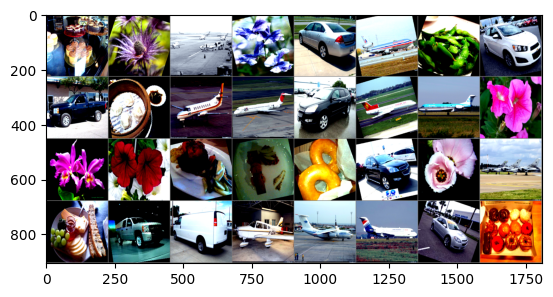

In [ ]:
# Visualize one image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for train_batch in train_loader:
    print("labels",train_batch[1])
    print("filename",train_batch[2])
    imshow(torchvision.utils.make_grid(train_batch[0]))
    break

In [ ]:
# from torchvision.models import efficientnet_b0,EfficientNet_B0_Weights
# weights = EfficientNet_B0_Weights.IMAGENET1K_V1
# # Get the pretrained model
# model = efficientnet_b0(weights=weights)

# from torchvision.models import vit_l_16, ViT_L_16_Weights

# weights = ViT_L_16_Weights.IMAGENET1K_V1
# # Get the pretrained model
# model = vit_l_16(weights=weights)

# from torchvision.models import resnet18,ResNet18_Weights
# weights = ResNet18_Weights.IMAGENET1K_V1
# # Get the pretrained model
# model = resnet18(weights=weights)

from torchvision.models import swin_b,Swin_B_Weights
weights = Swin_B_Weights.IMAGENET1K_V1
# Get the pretrained model
# model = swin_b(weights=weights, attention_dropout=0)
model = swin_b(weights=weights)

# from torchvision.models import swin_v2_b,Swin_B_Weights
# weights = Swin_B_Weights.IMAGENET1K_V1
# # Get the pretrained model
# model = swin_b(weights=weights)

# Change the last layer's output to 100 classes
model.heads= nn.Linear(1024, 100)

# Make the prameter of the last layer trainable
for param in model.parameters():
    param.requires_grad = True
model.heads.weight.requires_grad = True
model.heads.bias.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5, lr=0.0001)
model = model.to(device)

In [ ]:
# Fine tune the model
loss_history_train, loss_history_val= train_loop(model, train_loader, val_loader, criterion, optimizer, n_epochs=20, device=device)

# Save the model
# torch.save(model.state_dict(), '../models/vit_l_16_fine_tuned.pth')
torch.save(model.state_dict(), 'new_fine_tuned.pth')

Epoch 1/20, Loss: 2.6237, Accuracy: 0.2523
Epoch 2/20, Loss: 1.8234, Accuracy: 0.4206
Epoch 3/20, Loss: 1.3905, Accuracy: 0.5888
Epoch 4/20, Loss: 1.3654, Accuracy: 0.6168
Epoch 5/20, Loss: 1.5859, Accuracy: 0.6262
Epoch 6/20, Loss: 1.5010, Accuracy: 0.6542
Epoch 7/20, Loss: 1.6140, Accuracy: 0.6729
Epoch 8/20, Loss: 1.4439, Accuracy: 0.7383
Epoch 9/20, Loss: 1.3894, Accuracy: 0.7009
Epoch 10/20, Loss: 1.4760, Accuracy: 0.7103
Epoch 11/20, Loss: 1.5451, Accuracy: 0.7196
Epoch 12/20, Loss: 1.3589, Accuracy: 0.6729
Epoch 13/20, Loss: 1.3661, Accuracy: 0.6822
Epoch 14/20, Loss: 1.5102, Accuracy: 0.6636
Epoch 15/20, Loss: 1.5158, Accuracy: 0.7196
Epoch 16/20, Loss: 1.4477, Accuracy: 0.6636
Epoch 17/20, Loss: 1.7667, Accuracy: 0.6729
Epoch 18/20, Loss: 1.5815, Accuracy: 0.7009
Epoch 19/20, Loss: 1.4697, Accuracy: 0.6449
Epoch 20/20, Loss: 1.4161, Accuracy: 0.6822


In [ ]:
np.save('loss_history_train.npy', torch.tensor(loss_history_train))
np.save('loss_history_val.npy', torch.tensor(loss_history_val))


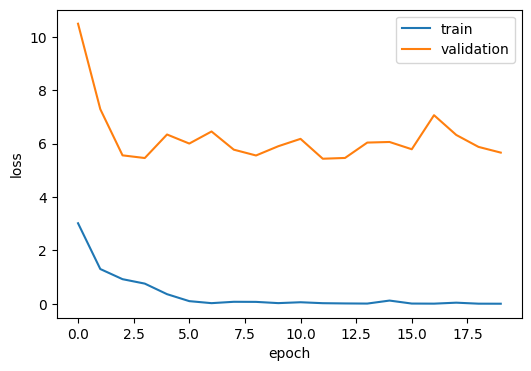

In [ ]:
loss_history_train = np.load('loss_history_train.npy')
loss_history_val = np.load('loss_history_val.npy')

# Plot the loss history
plt.figure(figsize=(6, 4))
plt.plot(loss_history_train, label='train')
plt.plot(loss_history_val, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [ ]:
# Load the fine tuned model
model_tuned = swin_b()
model_tuned.heads= nn.Linear(1024, 100)

model_tuned.load_state_dict(torch.load('new_fine_tuned.pth'))
model_tuned.to(device)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

In [ ]:
# Make predictions on the test set
y_pred = test_loop(model_tuned, test_loader, device)
y_pred

,ID,Label
0,0,57
1,1,43
2,2,38
3,3,62
4,4,42
...,...,...
1031,1031,31
1032,1032,4
1033,1033,1
1034,1034,77


In [ ]:
# Save the predictions
submit = pd.read_csv(path+'/sample_submission.csv')
submit['Label'] = y_pred['Label']
# submit.to_csv("result.csv", index=False)
submit

,ID,Label
0,0.jpg,57
1,1.jpg,43
2,2.jpg,38
3,3.jpg,62
4,4.jpg,42
...,...,...
1031,1031.jpg,31
1032,1032.jpg,4
1033,1033.jpg,1
1034,1034.jpg,77


In [ ]:
submit.to_csv("result_adam.csv", index=False)
submit

,ID,Label
0,0.jpg,57
1,1.jpg,43
2,2.jpg,38
3,3.jpg,62
4,4.jpg,42
...,...,...
1031,1031.jpg,31
1032,1032.jpg,4
1033,1033.jpg,1
1034,1034.jpg,77


In [ ]:
model = model_tuned
y_prob = pd.DataFrame(columns=['ID'])
model.eval()
with torch.no_grad():
    for inputs, _, file_name in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        # Get the probability
        prob = F.softmax(outputs, dim=1).cpu().numpy()
        prob = pd.DataFrame(prob)
        df = pd.DataFrame(file_name, columns=['ID'])
        # concat the probability and file name
        df = pd.concat([df, prob], axis=1)
        y_prob = pd.concat([y_prob, df], ignore_index=True)
y_prob= y_prob.sort_values('ID').reset_index(drop=True)
y_prob=y_prob.iloc[:,:101]

y_prob.to_csv("swin_b_output_other.csv", index=False)
y_prob

,ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,2.572308e-07,1.320340e-08,5.079134e-08,1.578685e-08,3.591342e-08,2.146588e-08,1.951402e-08,7.429635e-08,1.054189e-08,...,3.249821e-08,3.536532e-09,8.857952e-09,5.736384e-09,1.597309e-09,5.954147e-08,1.471545e-07,7.155336e-09,1.759878e-08,2.119301e-09
1,1,1.272169e-10,1.951595e-09,7.195558e-10,1.417149e-10,5.462840e-09,1.766516e-09,3.045676e-10,8.606914e-10,3.769360e-10,...,2.323281e-10,5.762516e-10,9.260433e-10,1.911363e-10,2.184495e-10,4.611248e-10,3.776347e-10,2.579089e-10,9.341934e-10,4.817481e-10
2,2,3.778739e-11,9.470761e-12,5.292321e-11,6.230444e-11,1.411129e-11,3.241740e-11,3.933211e-11,3.629745e-11,9.746570e-11,...,3.336749e-11,5.333604e-11,3.983394e-11,6.762080e-10,9.167793e-12,5.663837e-10,7.359371e-11,1.183881e-10,5.522911e-11,2.373930e-11
3,3,1.100746e-08,7.349296e-09,5.904371e-08,8.844306e-09,1.114376e-08,8.326764e-09,2.641737e-08,3.142669e-07,1.057726e-08,...,3.092610e-09,1.053708e-08,1.468924e-08,8.294982e-09,1.945951e-09,2.550501e-08,5.344305e-09,9.627740e-10,1.006697e-08,1.361821e-09
4,4,3.216410e-11,3.483809e-12,9.535864e-11,2.085199e-12,7.889790e-13,2.994858e-11,9.395669e-12,4.682671e-11,3.598137e-11,...,7.512851e-10,1.360405e-11,6.027043e-11,6.952410e-11,6.634337e-12,2.160324e-10,7.222744e-12,3.156593e-12,1.500559e-11,3.857784e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,1031,3.017375e-11,5.642146e-11,6.480484e-11,2.179728e-10,2.417299e-10,1.191017e-09,9.058778e-09,1.570554e-09,2.786192e-10,...,3.171725e-08,6.195453e-12,1.534828e-12,1.371463e-10,3.835695e-11,3.908536e-11,2.086219e-11,1.117063e-09,6.710167e-10,1.901519e-10
1032,1032,3.232574e-09,5.225397e-08,5.476436e-02,5.052992e-06,9.435062e-01,1.232244e-07,4.858777e-07,2.559287e-07,4.096963e-09,...,7.103733e-10,6.724354e-11,7.814897e-10,4.252798e-08,4.202399e-09,6.470984e-10,6.505722e-10,1.537872e-08,5.729213e-10,2.428616e-09
1033,1033,6.245910e-04,3.917854e-01,3.705712e-02,6.610870e-03,1.362071e-04,3.604470e-04,2.019054e-04,5.310686e-07,4.175310e-06,...,8.356101e-07,2.014721e-06,3.164815e-06,1.237433e-06,1.238083e-05,1.895628e-06,4.085916e-06,1.277374e-05,2.995166e-07,3.100323e-05
1034,1034,7.547396e-09,3.432651e-08,1.498449e-09,4.269980e-09,4.816810e-07,1.479671e-08,1.472279e-08,1.940818e-07,6.137049e-07,...,1.638865e-05,5.649102e-05,1.808458e-03,8.283331e-03,1.653642e-01,2.196963e-04,7.629440e-05,3.133491e-09,1.349676e-08,1.395834e-10


In [ ]:
# y_prob.to_csv("swin_b_output.csv", index=False)